# Tags

Predict tags for posts from [StackOverflow](https://stackoverflow.com)  using multilabel classification approach.

 

### Data

 

### Text preprocessing

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(eval)
    return data

In [ ]:
train = read_data('/content/data/train.tsv')
validation = read_data('/content/data/validation.tsv')
test = pd.read_csv('/content/data/test.tsv', sep='\t')

In [ ]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [ ]:
validation.iloc[4]['title']

'Getting error - type "json" does not exist - in Postgresql during rake db migrate'

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [ ]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [ ]:
y_train = train['tags'].values
y_val = validation['tags'].values

One of the most known difficulties when working with natural data is that it's unstructured. For example, if I use it "as is" and exatract tokens just by splitting the titles by whitespaces, I will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc.   

 

In [ ]:
import re

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text =REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text)# delete symbols which are not in GOOD_SYMBOLS_RE from text
    text =' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

Preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [ ]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [ ]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 

**WordsTagsCount.** Find 3 most popular tags and 3 most popular words in the train data.

In [ ]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}
from nltk import FreqDist
tg=list()
wor=list()
for i in X_train:
    wor.extend(i.split())
for j in y_train:
    tg.extend(j)
words_counts = dict(FreqDist(wor))
tags_counts = dict(Counter(tg))

### Transforming text to a vector

Machine Learning algoritms work with numeric data and   cannot use the provided text data "as is".  

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. Steps:
1. Find *N* most popular words in train corpus and numerate them. Now   having a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. for example  *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

Having a text, which   transform to the vector:

    'hi how are you'

For this text I create a corresponding zero vector 

    [0, 0, 0, 0]
    
And interate over all word, and if the word is in the dictionary, I increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Implement the described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find most common words use train data.  

In [ ]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {b[0]:a for a,b in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000])}
INDEX_TO_WORDS = {b:a for a,b in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    
    words = set(text.split())
    for i in words:
          if i in words_to_index.keys():
            result_vector[words_to_index[i]] = 1
    
    return result_vector

Now apply the implemented function to all samples:

In [ ]:
from scipy import sparse as sp_sparse

In [ ]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide a better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return bag-of-words representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer =tfidf_vectorizer = TfidfVectorizer( max_df=0.9, min_df=5,ngram_range=(1,2),token_pattern='(\S+)')  
    
     
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test= tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_

    Once I have done text preprocessing, always have a look at the results.  

In this case, checking whether I have c++ or c# in  vocabulary.

In [ ]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [ ]:
 'c++' in tfidf_vocab.values()


False

In [ ]:
'c#' in  [tfidf_reversed_vocab.values()]


False

Now, use this transormation for the data and check again.

In [ ]:
 'c++' in tfidf_reversed_vocab.values()


True

In [ ]:
'c#' in  list(tfidf_reversed_vocab.values())


True

### MultiLabel classifier

 

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [ ]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    clf = LogisticRegression(solver='lbfgs')
    clf = OneVsRestClassifier(clf)
    clf.fit(X_train, y_train)
    
    return clf

Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [ ]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look how classifier which uses tfidf works for a few examples:

In [ ]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




### Evaluation

 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [ ]:
def print_evaluation_scores(y_val, predicted):
    print ("Accracy={}".format(accuracy_score(y_val, predicted)) )  
    print ("F1_macro={}".format(f1_score(y_val, predicted, average='macro')))
    print ("F1_micro={}".format(f1_score(y_val, predicted, average='micro')))
    print ("F1_weighted={}".format(f1_score(y_val, predicted, average='weighted')))
    print ("Precsion_macro={}".format(average_precision_score(y_val, predicted, average='macro')))
    print ("Precsion_micro={}".format(average_precision_score(y_val, predicted, average='micro')))
    print( "Precsion_weighted={}".format(average_precision_score(y_val, predicted, average='weighted')))


In [ ]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accracy=0.3614
F1_macro=0.5083536128324068
F1_micro=0.6738958990536278
F1_weighted=0.6517215878527387
Precsion_macro=0.3486672699602888
Precsion_micro=0.48467595072354575
Precsion_weighted=0.5139947248983571
Tfidf
Accracy=0.33393333333333336
F1_macro=0.44547734076336937
F1_micro=0.641725515957738
F1_weighted=0.6142558095892964
Precsion_macro=0.3018183381759166
Precsion_micro=0.4569104306861487
Precsion_weighted=0.4850179975040079


In [ ]:
from metrics import roc_auc
%matplotlib inline

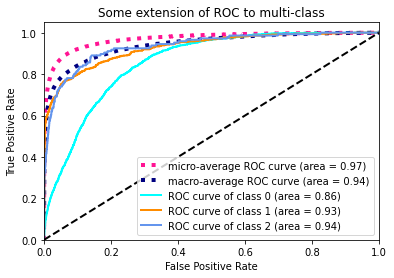

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

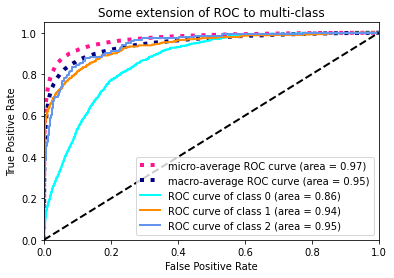

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**MultilabelClassification .**  

In [ ]:
clf1 = LogisticRegression(C = 0.1)
clf1 = OneVsRestClassifier(clf1)
clf1.fit(X_train_mybag, y_train)

clf2 = LogisticRegression(C = 1)
clf2 = OneVsRestClassifier(clf2)
clf2.fit(X_train_mybag, y_train)

clf3 = LogisticRegression(C = 10)
clf3 = OneVsRestClassifier(clf3)
clf3.fit(X_train_mybag, y_train)

clf4 = LogisticRegression(C = 100)
clf4 = OneVsRestClassifier(clf4)
clf4.fit(X_train_mybag, y_train)

clf5 = LogisticRegression(C = 0.1,penalty = 'l2',solver='lbfgs')
clf5 = OneVsRestClassifier(clf1)
clf5.fit(X_train_mybag, y_train)

clf6 = LogisticRegression(C = 1,penalty = 'l2',solver='lbfgs')
clf6 = OneVsRestClassifier(clf2)
clf6.fit(X_train_mybag, y_train)

clf7 = LogisticRegression(C = 10,penalty = 'l2',solver='lbfgs')
clf7 = OneVsRestClassifier(clf3)
clf7.fit(X_train_mybag, y_train)

clf8 = LogisticRegression(C = 100,penalty = 'l2',solver='lbfgs' )
clf8 = OneVsRestClassifier(clf4)
clf8.fit(X_train_mybag, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


OneVsRestClassifier(estimator=OneVsRestClassifier(estimator=LogisticRegression(C=100,
                                                                               class_weight=None,
                                                                               dual=False,
                                                                               fit_intercept=True,
                                                                               intercept_scaling=1,
                                                                               l1_ratio=None,
                                                                               max_iter=100,
                                                                               multi_class='auto',
                                                                               n_jobs=None,
                                                                               penalty='l2',
                                                       

In [ ]:
y_pred_bag_1 = clf1.predict(X_val_mybag)
y_pred_bag_2 = clf5.predict(X_val_mybag)
print('C=0.1, l1, f1_score_weighte = ', f1_score(y_val, y_pred_bag_1, average='weighted'))
print('C=0.1, l2, f1_score_weighte = ', f1_score(y_val, y_pred_bag_2, average='weighted'))

C=0.1, l1, f1_score_weighte =  0.5924719280738858
C=0.1, l2, f1_score_weighte =  0.5924719280738858


### Analysis of the most important features

Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in   logistic regression model.

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [ ]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    coefficiens = classifier.coef_[tags_classes.index(tag)]
    top_positive_words = [index_to_words[coefficien] for coefficien in coefficiens.argsort()[5:]]# top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[coefficien] for coefficien in coefficiens.argsort()[:5]]# bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [ ]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	objective c, objective, jquery, ruby, swift, rails, class, c++, r, django, object, exception, page, html, aspnet, json, method, form, database, spring, vbnet, button, net, objects, image, custom, android, linq, mysql, ajax, property, codeigniter, template, google, wpf, angularjs, url, sql, js, laravel, app, xml, add, query, numpy, get, date, regex, mvc, load, classes, text, nsstring, data, web, nodejs, event, qt, hibernate, typeerror, unable, service, boost, working, div, cannot, controller, table, framework, pdf, detect, pandas, column, collection, change, list, excel, click, angular, application, show, map, textbox, model, new, maven, insert, chrome, field, images, listview, css, facebook, session, row, view, arraylist, remove, jar, bootstrap, ios, validation, attribute, script, email, wordpress, matplotlib, properties, datatable, foreach, jsp, instance, tomcat, selected, tag, stl, vector, post, entity, display, lambda, constructor, datetime, gridview, canv